In [63]:
%load_ext autoreload
%autoreload 2
import math
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import statistics
import scipy
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import data_cleaning_greg  as dc
import hypothesis_tests as ht
import visualizations

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Our 4 Hypotheses
### - Does Netflix perform better against it's competitors?
We will 
###
###
###

Our significance lelvel will be  p>0.05. 
This states that there is a 5% chance that, given the null hypothesis is true, that these results will be stocastic (due to random chance).

We will also correct our significance level for repeat testing by using Bonferroni correction if required.

In [64]:
# Set our values for statistical signicance testing - using convention.
alpha = 0.05
beta = 0.8
power=1 - beta


## Reading in the data and begin cleaning

The below dataset is based on the last five years' worth of films released in the United States. It is a combination of data scraped from the International Movie Database (IMDb) website, csv files found on IMDb and the OMDb API. 
The scraped data was used for the gross profit of each film; by using budget and revenue we can estimate the profit .
Full_OMDB_Table.csv contains a list of movies (country USA, language English) from November 2014 to October 2019 taken from IMDB. Budget and revenue info are from IMDB as well.  Ratings (IMDB, Rotten Tomatoes and Metascore), released date, actors and production info are from OMDB, unoffical IMDB API.

In [65]:
# Read in data as pandas dataframe

df=pd.read_csv("2016_2019_USmovies_API.csv")
df.head()

# Check what our column titles are so we can rename/remove them
df.columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2015 entries, 0 to 2014
Data columns (total 22 columns):
tconst                      2015 non-null object
titleType                   2015 non-null object
primaryTitle                2015 non-null object
originalTitle               2015 non-null object
isAdult                     2015 non-null int64
startYear                   2015 non-null int64
endYear                     2015 non-null object
runtimeMinutes              2015 non-null int64
genres                      2015 non-null object
title                       2015 non-null object
check                       2015 non-null int64
averageRating               2015 non-null float64
numVotes                    2015 non-null int64
budget_LCY                  1004 non-null object
gross_USA_USD               1085 non-null float64
cumm_worldwide_gross_USD    1386 non-null float64
Released_Date               2005 non-null object
Released_Month              2005 non-null float64
Rotten_Tomat

In [66]:
# Let's clean the data and rename columns so we know what we're looking 

columns=["tconst","title","isAdult","startYear","runtimeMinutes","check","averageRating","genres","numVotes",
         "budget_LCY","gross_USA_USD","cumm_worldwide_gross_USD",]
names=["Title_ID","Title","Adult","Release_Year","Runtime(Minutes)","Check","Rating","Genre","Number_of_Votes",
      "Budget(LCY)","USA_Gross($)","Worldwide_Gross($)"]
columns_to_drop=["titleType","primaryTitle","originalTitle","endYear","Adult","Check"]

dc.full_clean(df, columns, names, columns_to_drop)

# Save as csv
# df.to_csv("Full_OMDB_Table.csv",index=False)

df.head()

,Title_ID,Release_Year,Runtime(Minutes),Genre,Title,Rating,Number_of_Votes,Budget(LCY),USA_Gross($),Worldwide_Gross($),Released_Date,Released_Month,Rotten_Tomatoes,Metascore,Actors,Production
0,tt0069049,2018,122,Drama,The Other Side of the Wind,6.9,4989,NaN,NaN,NaN,02 Nov 2018,11.0,83.0,78.0,"John Huston, Oja Kodar, Peter Bogdanovich, Sus...",Netflix
1,tt0339736,2017,98,Horror,The Evil Within,5.5,2572,$6000000,NaN,NaN,30 Aug 2017,8.0,100.0,NaN,"Sean Patrick Flanery, Dina Meyer, Frederick Ko...",NaN
2,tt0360556,2018,100,"Drama,Sci-Fi,Thriller",Fahrenheit 451,4.9,15295,NaN,NaN,NaN,20 May 2018,5.0,32.0,NaN,"Michael B. Jordan, Aaron Davis, Cindy Katz, Mi...",HBO Films
3,tt0365545,2018,98,"Comedy,Drama,Romance",Nappily Ever After,6.4,6718,NaN,NaN,NaN,21 Sep 2018,9.0,71.0,63.0,"Sanaa Lathan, Ricky Whittle, Lyriq Bent, Lynn ...",Netflix
4,tt0369610,2015,124,"Action,Adventure,Sci-Fi",Jurassic World,7.0,549806,$150000000,652.27,1670.4,12 Jun 2015,6.0,72.0,59.0,"Chris Pratt, Bryce Dallas Howard, Irrfan Khan,...",Universal Pictures


In [67]:
df.columns

Index(['Title_ID', 'Release_Year', 'Runtime(Minutes)', 'Genre', 'Title',
       'Rating', 'Number_of_Votes', 'Budget(LCY)', 'USA_Gross($)',
       'Worldwide_Gross($)', 'Released_Date', 'Released_Month',
       'Rotten_Tomatoes', 'Metascore', 'Actors', 'Production'],
      dtype='object')

In [68]:
# Now to check our data makes sense and we have no nulls
print(df.describe())
print(df.info())
print(df.shape)

       Release_Year  Runtime(Minutes)       Rating  Number_of_Votes  \
count   2015.000000       2015.000000  2015.000000      2015.000000   
mean    2016.715633        101.181141     5.920447     42005.702233   
std        1.355422         15.783114     1.051272     91376.330598   
min     2014.000000         46.000000     1.400000       984.000000   
25%     2016.000000         90.000000     5.300000      2377.500000   
50%     2017.000000         98.000000     6.000000      7601.000000   
75%     2018.000000        109.000000     6.600000     36685.500000   
max     2019.000000        209.000000    10.000000    844981.000000   

       USA_Gross($)  Worldwide_Gross($)  Released_Month  Rotten_Tomatoes  \
count   1085.000000         1386.000000     2005.000000      1522.000000   
mean      46.304341           91.579856        6.684788        55.818660   
std       91.560188          225.040751        3.378692        28.335085   
min        0.000000            0.000000        1.000000 

## Subset our data to what we're interested in.
Since we will be looking at genres we want to see what different genres we have and split these into different categories. We will also be interested in the production company -> IE Netflix

In [69]:
df.columns

Index(['Title_ID', 'Release_Year', 'Runtime(Minutes)', 'Genre', 'Title',
       'Rating', 'Number_of_Votes', 'Budget(LCY)', 'USA_Gross($)',
       'Worldwide_Gross($)', 'Released_Date', 'Released_Month',
       'Rotten_Tomatoes', 'Metascore', 'Actors', 'Production'],
      dtype='object')

In [70]:
# Drop columns which contain nulls as they aren't relevant to ratings.
# We will drop rotten tomatoes scores as the user base is far smaller than imdb and will skew our results.
# Metascore is also not comparable as these are not user based scores they are weighted critic reviews

df_ratings=df.drop(columns=["Released_Month","Released_Date","Rotten_Tomatoes","Metascore"])


In [83]:
# How many genres are in our dataset?
len(df_ratings.Genre.unique())

246

As can be seen from the above output, we have over 200 combinations of genres. Therefore due to complexity of investigating each unique combination and bearing in mind the aim of this project is to perform several significance tests, we will only investigate "pure" genres, IE purely drama or purely action.

In [84]:
# Now split into separate databases based on pure genres.

df_comedy=df_ratings.loc[df_ratings["Genre"]=="Comedy",:]
df_drama=df_ratings.loc[df_ratings["Genre"]=="Drama",:]
df_horror=df_ratings.loc[df_ratings["Genre"]=="Horror",:]
df_scifi=df_ratings.loc[df_ratings["Genre"]=="Sci-Fi",:]
df_action=df_ratings.loc[df_ratings["Genre"]=="Action",:]
df_romance=df_ratings.loc[df_ratings["Genre"]=="Romance",:]
df_adventure=df_ratings.loc[df_ratings["Genre"]=="Adventure",:]


# Print shape of dataframe so we know the sample sizes

print("There are ",len(df_drama),"Drama movies in this dataset")
print("There are ",len(df_comedy),"Comedy movies in this dataset")
print("There are ",len(df_horror)," Horror movies in this dataset")
print("There are ",len(df_action),"  Action movies in this dataset")
print("There are ",len(df_scifi),"  Sci-Fi movies in this dataset")
print("There are ",len(df_romance),"  Romance movies in this dataset")
print("There are ",len(df_adventure),"  Adventure movies in this dataset")


There are  112 Drama movies in this dataset
There are  101 Comedy movies in this dataset
There are  64  Horror movies in this dataset
There are  7   Action movies in this dataset
There are  4   Sci-Fi movies in this dataset
There are  3   Romance movies in this dataset
There are  0   Adventure movies in this dataset


From the above, our most populated genres in this data set are Drama, Comedy and Horror. Therefore, due to our data, we will focus our investigation on these 3. Below a boxplot shows how these genres ratings perform against each other.

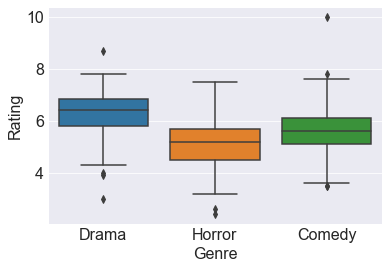

In [80]:
# Concat tables together to plot boxplots on same graph
df_cdh=df_ratings.loc[((df_ratings["Genre"]=="Comedy")|(df_ratings["Genre"]=="Drama")|(df_ratings["Genre"]=="Horror")),:]

sns.boxplot(data=df_cdh, x="Genre",y="Rating")

Drama has the highest rating based on the mean and variance ignoring outliers.

In [95]:
# Can we perform an ANOVA on our data for 3 main title types to see if statistically different?
# sample sizes vary between all genres so choosing the top 3 and will take n=60 random sample

comedy=df_comedy.Rating.sample(n=60)
drama=df_drama.Rating.sample(n=60)
horror=df_horror.Rating.sample(n=60)


## Is the difference in rating for each genre signifcant?
### What is the best genre to choose to maximise rating?

In this section we will perform a simple one-way ANOVA just to see if our main 3 genres difference in ratings is statistically significant. From this and the accompanying visualization, we will then see if Drama (our highest ranking genre) garners a higher rating than the average movie and perform a simple z-test to see if the result is signifcant (IE compare to the population of all genres excluding Drama). The reason for this approach is so we can see which genre would be best to make a movie for.

Our hypothesis is that there will be a signifcant difference between genres and that drama will be the best performing, such that the rating of drama films is higher than the average rating for the population.
Our Null is that there is no difference.

## Now we need to plot our data to check for normality

If we plan to use a simple ANOVA or z-test, we need our data to obey a normal distribution. Below we will check for this and if not, we can use the central limit theorem to randomly sample our data and re-plot it until we get a uniform distribution.

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


NormaltestResult(statistic=23.449723558628776, pvalue=8.090162186543765e-06)
NormaltestResult(statistic=10.265149246209504, pvalue=0.005901347153072715)
NormaltestResult(statistic=1.6955154216018085, pvalue=0.4283743951291268)


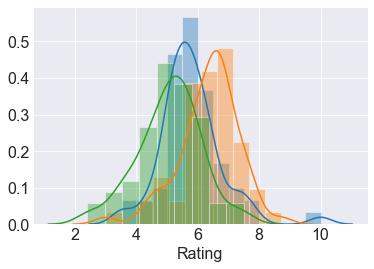

In [139]:
sns.distplot(comedy)   # Blue
sns.distplot(drama)    # Green
sns.distplot(horror)   # Red
print(st.normaltest(comedy))
print(st.normaltest(drama))
print(st.normaltest(horror))

Using the above "normaltest" we can check to see if the data obeys a normal distribution. If the p-value is less than 0.05 we reject the null hypthesis which says the data is normal. Therefore we need a p-value > 0.05 to say it is normal, such as the horror data-set.

As we will be comparing drama to the population, let's do the same for the population and the full drama data-set.

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


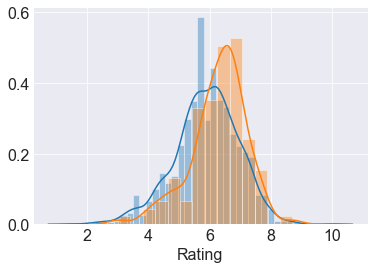

In [72]:
# Remove our sample set from the population so it doesn't skew our mean and plot against each other.

df_no_drama=df_ratings.loc[df_ratings["Genre"]!="Drama",:]

sns.distplot(df_no_drama.Rating)
sns.distplot(df_drama.Rating)

# sns.distplot(df_comedy.Rating)
# sns.distplot(df_horror.Rating)
# sns.distplot(df_scifi.Rating)
# sns.distplot(df_action.Rating)
# sns.distplot(df_romance.Rating)

In [73]:
print("For the population the standard deviation is:",round(df_no_drama.Rating.std(),3)," with a median value of:",round(df_no_drama.Rating.median(),3)," and a mean value of:",round(df.Rating.mean(),3))
print("For Drama the standard deviation is:",round(df_drama.Rating.std(),3)," with a median value of:",round(df_drama.Rating.median(),3)," and a mean value of:",round(df_drama.Rating.mean(),3))
print("This gives us an effect size of", round(ht.cohens_d(df_drama.Rating, df_no_drama.Rating),3), "(to 3dp.)")

For the population the standard deviation is: 1.055  with a median value of: 6.0  and a mean value of: 5.92
For Drama the standard deviation is: 0.917  with a median value of: 6.4  and a mean value of: 6.292
This gives us an effect size of 0.398 (to 3dp.)


In [74]:
print("The drama movies sample set is not normal given: ",st.normaltest(df_drama.Rating),"\n It has ",len(df_drama)," values.")
print("The rest of the data is not normal given: ",st.normaltest(df_no_drama.Rating),"\n It has ",len(df_no_drama)," values.")


The drama movies sample set is not normal given:  NormaltestResult(statistic=15.285855141424646, pvalue=0.00047942285126625054) 
 It has  112  values.
The rest of the data is not normal given:  NormaltestResult(statistic=58.066922240332374, pvalue=2.459959997803095e-13) 
 It has  1903  values.


So neither the population or Drama data-sets are normal either. 

## Improve our data set such that it is normal and we can perform our tests!

Below we will use the Central Limit Theorem to aid in creating normal distributions for our data. We will randomly sample horror too, even though it is already normal, so we have equal sizes of the distributions.

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


NormaltestResult(statistic=1.4464791415082396, pvalue=0.48517793901946826)
NormaltestResult(statistic=2.0252718938826524, pvalue=0.36326018189141596)
NormaltestResult(statistic=0.9603182827824502, pvalue=0.6186849255915348)


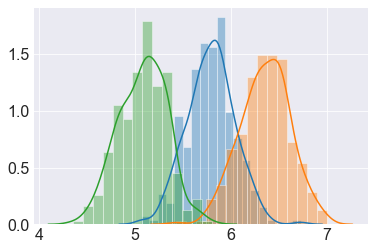

In [145]:
comedy_normal=ht.create_sample_distribution(comedy,300,n=15)
drama_normal=ht.create_sample_distribution(drama,300,n=15)
horror_normal=ht.create_sample_distribution(horror,300,n=15)

sns.distplot(comedy_normal)
sns.distplot(drama_normal)
sns.distplot(horror_normal)

print(st.normaltest(comedy_normal))
print(st.normaltest(drama_normal))
print(st.normaltest(horror_normal))



### Performing a simple one-way ANOVA for our 3 main genres...
The aim of this is to see whether the difference in ratings between genres is signifcantly different.
If so, we will we be interested in to see the how drama performs against the population. We will not perform ad-hoc comparisons between genres as we are not interested in which specific combinations are signifcant but rather just interested in seeing if any observed difference is real.

In [146]:
# Now perform a one-way ANOVA test for these random samples
anova=scipy.stats.f_oneway(comedy_normal,drama_normal,horror_normal)     

# Very small P-value and large F -> signifcant difference between genres
ht.significance(anova[1],alpha) 

'We reject the null as our p-value (0.0) is less than our alpha (0.05) so we can say this result is signifcant.'

We can see the above genres are statistically different from each other, so genres definitely affect the rating. As drama has the highest rating, we now want to know if it statistically different from the population, thereby saying drama films do garner a better rating, and can advise which is the genre most likely to be a success.

## Drama vs Population
Again we will need to normalise these two data-sets.

NormaltestResult(statistic=9.412700535953876, pvalue=0.009037702654836966)


/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


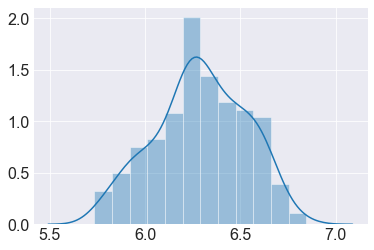

In [111]:
drama_normal=ht.create_sample_distribution(df_drama.Rating,300,n=15)
sns.distplot(drama_normal)
print(st.normaltest(drama_normal))

NormaltestResult(statistic=0.35588958540681975, pvalue=0.8369886300928296)


/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


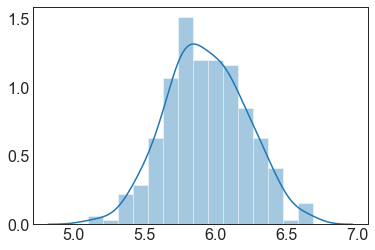

In [58]:
no_drama_normal=ht.create_sample_distribution(df_no_drama.Rating,300,n=15)
sns.distplot(no_drama_normal)
print(st.normaltest(no_drama_normal))

In [61]:
print("For the population the standard deviation is:",round(statistics.pstdev(no_drama_normal),3)," with a median value of:",round(statistics.median(no_drama_normal),3)," and a mean value of:",round(statistics.mean(no_drama_normal),3))
print("For Drama the standard deviation is:",round(statistics.stdev(drama_normal),3)," with a median value of:",round(statistics.median(drama_normal),3)," and a mean value of:",round(statistics.mean(drama_normal),3))
print("This gives us an effect size of", round(ht.cohens_d(drama_normal, no_drama_normal),3), "(to 3dp.)")

For the population the standard deviation is: 0.28  with a median value of: 5.92  and a mean value of: 5.933
For Drama the standard deviation is: 0.238  with a median value of: 6.303  and a mean value of: 6.278
This gives us an effect size of 1.328 (to 3dp.)


### Plotting our normalised distributions

## One sample z-test for Drama movies against the population.

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


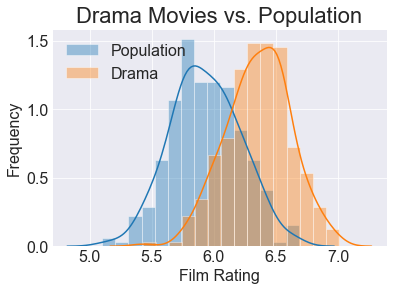

In [148]:
a = sns.distplot(no_drama_normal,label="Population").set_title("Drama Movies vs. Population").get_figure().savefig("Drama_vs_Popluation.png")
b = sns.distplot(drama_normal,label="Drama")
plt.xlabel("Film Rating")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [149]:
alpha =  0.05                                   # The alpha value - likelihood to avoid a Type 1 error

ht.z_test(drama_normal, no_drama_normal, alpha)               # Using the z-test from our library

The z-statistic is 26.294, which corresponds to a p-value of 0.0.
The effect size, cohen's d = 1.576.
From this we Reject the null hypothesis


Therefore the difference in rating between Drama and the population is significant with a large effect size!

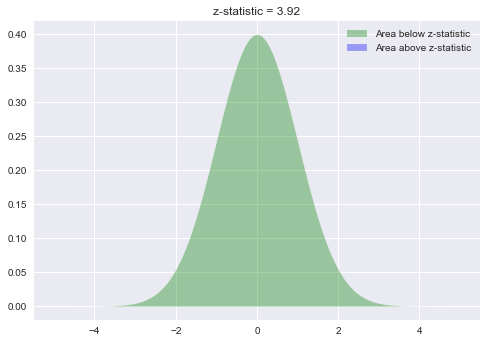

In [150]:
# Visualize the difference

plt.style.use('seaborn')
plt.fill_between(x=np.arange(-5,3.92,0.01),
                 y1= st.norm.pdf(np.arange(-5,3.92,0.01)),
                 facecolor='green',
                 alpha=0.35,
                 label= 'Area below z-statistic'
                 )

plt.fill_between(x=np.arange(3.92,5,0.01), 
                 y1= st.norm.pdf(np.arange(3.92,5,0.01)),
                 facecolor='blue',
                 alpha=0.35, 
                 label= 'Area above z-statistic')
plt.legend()
plt.title ('z-statistic = 3.92');

## How do Netflix films compare to the population?
In this section we will use a Welch's T-Test as our variance in the Netflix subset and population do not have equal variance (as are not uniform) so this test will be more appropriate without having to normalise our dataset as we did previously. However as we will have both normalised and non-normal versions we will perform both tests.

Our hypothesis is that Netflix films will perform better or worse than the population - IE they will differ in rating.
Our null is that there is no difference between Netflix films and the population.

In [151]:
# How many films does Netflix have here and how many are drama?
print("Netflix has ",len(df_ratings.loc[df_ratings["Production"]=="Netflix",:])," films in total.")
print("Netflix has ",len(df_ratings.loc[(df_ratings["Production"]=="Netflix")&(df_ratings["Genre"]=="Drama"),:]),"  Drama films.")

Netflix has  122  films in total.
Netflix has  10   Drama films.


In [152]:
df_ratings.info()
df_ratings.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2015 entries, 0 to 2014
Data columns (total 12 columns):
Title_ID              2015 non-null object
Release_Year          2015 non-null int64
Runtime(Minutes)      2015 non-null int64
Genre                 2015 non-null object
Title                 2015 non-null object
Rating                2015 non-null float64
Number_of_Votes       2015 non-null int64
Budget(LCY)           1004 non-null object
USA_Gross($)          1085 non-null float64
Worldwide_Gross($)    1386 non-null float64
Actors                2015 non-null object
Production            1678 non-null object
dtypes: float64(3), int64(3), object(6)
memory usage: 189.0+ KB


Index(['Title_ID', 'Release_Year', 'Runtime(Minutes)', 'Genre', 'Title',
       'Rating', 'Number_of_Votes', 'Budget(LCY)', 'USA_Gross($)',
       'Worldwide_Gross($)', 'Actors', 'Production'],
      dtype='object')

In [153]:
df_netflix = df_ratings.loc[df_ratings["Production"]=="Netflix",:]
df_rest    = df_ratings.loc[df_ratings["Production"]!="Netflix",:]

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


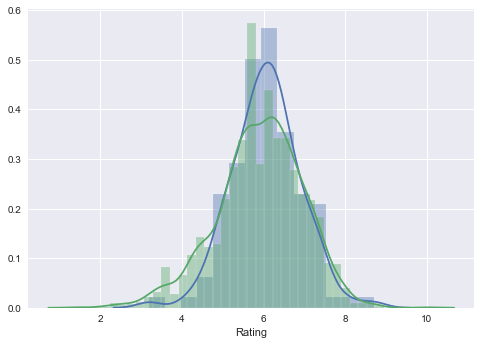

In [154]:
sns.distplot(df_netflix.Rating)
sns.distplot(df_rest.Rating)

In [155]:
print(df_rest.Rating.std(),df_rest.Rating.mean())
print(df_netflix.Rating.std(),df_netflix.Rating.mean())


1.0629724003438397 5.911251980982567
0.8400315637194714 6.06311475409836


### Let's create a normal distribution for each data-set for our z-test.
We will still use our original data-set for the Welch's as this test accounts for different sample sizes and variances. IE it doesn't need to be uniform.

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


NormaltestResult(statistic=0.7461972479605632, pvalue=0.6885973172867175)


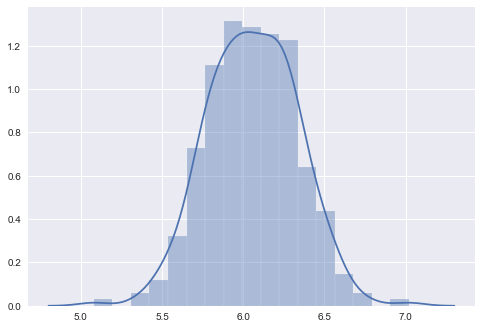

In [164]:
netflix_normal=ht.create_sample_distribution(df_netflix.Rating,300,n=10)
sns.distplot(netflix_normal)
print(st.normaltest(netflix_normal))

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


NormaltestResult(statistic=0.8643695341512423, pvalue=0.6490894352481069)


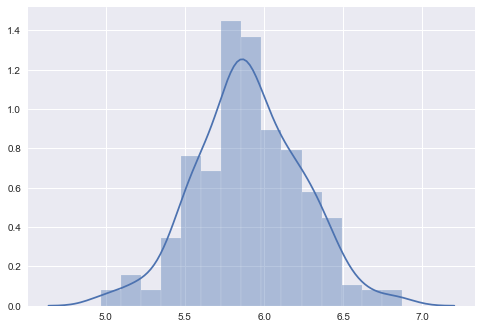

In [165]:
rest_normal=ht.create_sample_distribution(df_rest.Rating,300,n=10)
sns.distplot(rest_normal)
print(st.normaltest(rest_normal))

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


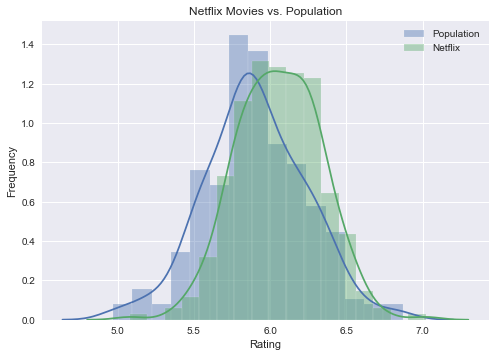

In [166]:
a=sns.distplot(rest_normal,label="Population").set_title("Netflix Movies vs. Population").get_figure().savefig("Netflix_vs_Popluation.png")
b=sns.distplot(netflix_normal,label="Netflix")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.legend()
plt.show()



In [167]:
print(len(rest_normal))
len(netflix_normal)

300


300

### Perform simple z-test
As we have normalized our sample sets here, and they both have the same sample size, we can perform a z-test.

In [171]:
z_netflix = ht.z_test(netflix_normal,rest_normal,alpha)       
z_netflix

The z-statistic is 8.008, which corresponds to a p-value of 5.551115123125783e-16.
The effect size, cohen's d = 0.504.
From this we Reject the null hypothesis
This gives us a t-statistic of 6.163, and a corresponding p-value of 0.0


### Perform Welch's T-Test
If we do not want to use our normlized data, perhaps for better accuracy as this method uses the true distribution, we can use a Welch's T-test which accounts for non-uniformity and different sample sizes. 

In [170]:
# We can perform a welchs t-test in one line using scipy.stats

t_stat, p_value = st.ttest_ind(df_netflix.Rating, df_rest.Rating, equal_var=False)

print(f"This gives us a t-statistic of {round(t_stat,3)}, and a corresponding p-value of {round(p_value,3)}")

ht.significance(p_value,alpha)


This gives us a t-statistic of 1.901, and a corresponding p-value of 0.059


'Fail to reject the null as our p-value (0.059) is greater than our alpha (0.05) so the result is not signifcant.'

Interestingly we can see that when we perform a Welch's t-test, this tells us our result is not significant, unlike our normalized z-test. In this case, we will take the result of our Welch's test and say the result is not signifcant, as this test uses the full, unaltered sample-set without sampling and so is likely to be more representative.

### Is it more profitable to release movies during the winter months in the US?

The dataset is base on the last five years' worth movies released in the US scraped from IMDB for the ratings and gross profit.  Profitability will be measured using the budget (proxy for overall production cost converted into USD) and gross US revenue (not worldwide revenue as focus is revenue during the winter) scraped from each of the movie IMDB webpages. t-test will be performed on the mean profits of winter (Dec, Jan, Feb) and summer (Jun, Jul, Aug) movies.

#### Perform EDA on  the data taken from IMDB.  Check for null values and outliers.

In [ ]:
#Get the columns needed for the test:  movies released during the winter months more profitable
df_movie_revenue = df[["Title_ID","Release_Year","Released_Month","Title","Genre","Production","Budget(LCY)","USA_Gross($)","Worldwide_Gross($)"]]
df_movie_revenue.head()

In [ ]:
#Check dtype and for null values
display(df_movie_revenue.info())

In [ ]:
#Drop null values under the money columns
df_movie_revenue.dropna(subset = ["Budget(LCY)", "USA_Gross($)", "Worldwide_Gross($)"], inplace = True)
df_movie_revenue.info()

In [ ]:
#Convert budget column to USD, use current exchange rate
df_movie_revenue["Budget($)"] = pd.Series([])

for i in range(len(df_movie_revenue)):
    if str(df_movie_revenue["Budget(LCY)"].iloc[i])[0] == "$":
        df_movie_revenue["Budget($)"].iloc[i] = int(str(df_movie_revenue["Budget(LCY)"].iloc[i]).replace("$",""))/1000000
    elif str(df_movie_revenue["Budget(LCY)"].iloc[i])[0:3] == "EUR":
        df_movie_revenue["Budget($)"].iloc[i] = int(str(df_movie_revenue["Budget(LCY)"].iloc[i]).replace("EUR",""))/1000000 * 1.1
    elif str(df_movie_revenue["Budget(LCY)"].iloc[i])[0:3] == "GBP":
        df_movie_revenue["Budget($)"].iloc[i] = int(str(df_movie_revenue["Budget(LCY)"].iloc[i]).replace("GBP",""))/1000000 * 1.28
    elif str(df_movie_revenue["Budget(LCY)"].iloc[i])[0:3] == "CAD":
        df_movie_revenue["Budget($)"].iloc[i] = int(str(df_movie_revenue["Budget(LCY)"].iloc[i]).replace("CAD",""))/1000000 * 0.75
    else:
        continue
        
df_movie_revenue.drop(columns = ["Budget(LCY)"], axis = 1, inplace = True)

In [ ]:
#Calculate US profit
df_movie_revenue["Profit_US(%)"] = round((df_movie_revenue["USA_Gross($)"] / df_movie_revenue["Budget($)"]) - 1, 2)

#Calculate Worldwide profit
df_movie_revenue["Profit_W(%)"] = round((df_movie_revenue["Worldwide_Gross($)"] / df_movie_revenue["Budget($)"]) - 1, 2)

In [ ]:
df_movie_revenue.info()

In [ ]:
plt.figure(figsize = [10,5])
sns.scatterplot(data = df_movie_revenue, x = "Budget($)", y = "Worldwide_Gross($)", label = "Worldwide Gross Revenue")
sns.scatterplot(data = df_movie_revenue, x = "Budget($)", y = "USA_Gross($)", label = "US Gross Revenue")
plt.xlabel("Budget US$ mm")
plt.ylabel("Revenue US$ mm")
plt.legend()
plt.savefig("BudgetvsGrossRevenues")
plt.show()

In [ ]:
#Add categorial columns for the seasons
df_months = pd.DataFrame({"Released_Month" : list(range(1,13)), "Season" : [1,1,2,2,2,3,3,3,4,4,4,1], "Season_" : [1,1,2,2,2,2,2,2,1,1,1,1]})
df_season_revenue = pd.merge(df_movie_revenue, df_months, on = "Released_Month")
df_season_revenue

In [ ]:
#Check the distribution of the profit column
plt.figure(figsize = [20,5])
sns.boxplot(df_season_revenue["Profit_US(%)"])

In [ ]:
df_season_revenue["Profit_US(%)"].describe()

In [ ]:
#The above boxplot and table are showing 4 outliers above 15/20%
#Remove the outliers profit > 15%
df_season_outliers = df_season_revenue[df_season_revenue["Profit_US(%)"] > 15]
df_season_outliers

In [ ]:
df_season_revenue = df_season_revenue[df_season_revenue["Profit_US(%)"] <= 15]
df_season_revenue

In [ ]:
plt.figure(figsize = [20,5])
sns.boxplot(df_season_revenue["Profit_US(%)"])

In [ ]:
sns.scatterplot(data = df_season_revenue, x = "Budget($)", y = "USA_Gross($)")

In [ ]:
#Create a subset for winter movies
df_winter = df_season_revenue[(df_season_revenue["Season"] == 1)]
df_winter["Profit_US(%)"].describe()

In [ ]:
#Create a subset for summer movies which will be tested against winter movies
df_summer = df_season_revenue[(df_season_revenue["Season"] == 3)]
df_summer["Profit_US(%)"].describe()

In [ ]:
#Check distribution
sns.distplot(df_winter["Profit_US(%)"])
sns.distplot(df_summer["Profit_US(%)"])

#### For the above subsets, perform random sampling then compare sample variances and check for normality.

H0: sample comes from a normal distribution

HA: sample does not from a normal distribution

In [ ]:
#Below functions perform random sampling and calculate for sample variance
def get_sample_mean(sample):
    return sum(sample) / len(sample)
def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x)  
    return sample
def create_sample_distribution(data, dist_size=100, n=30):
    sample_dist = []
    while len(sample_dist) != dist_size:
        sample = get_sample(data, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    return sample_dist
def sample_variance(sample):
    sample_mean = np.mean(sample)
    return np.sum((sample - sample_mean) **2)/ (len(sample) -1)

In [ ]:
#Perfom random sampling and normality test on winter movies
winter_sample = create_sample_distribution(df_winter["Profit_US(%)"], dist_size=100, n=30)
stats.normaltest(winter_sample)

In [ ]:
#Perfom random sampling and normality test on summer movies
summer_sample = create_sample_distribution(df_summer["Profit_US(%)"], dist_size=100, n=30)
stats.normaltest(summer_sample)

In [ ]:
sns.distplot(winter_sample, label = "Winter Movies Ave Profit (%)")
sns.distplot(summer_sample, label = "Summer Movies Ave Profit (%)")
plt.legend()
plt.savefig("WinterSummer", bbox_inches = "tight")
plt.show()

In [ ]:
winter_variance = sample_variance(winter_sample)
winter_mean = np.mean(winter_sample)
print("winter sample mean is", winter_mean)
print("winter sample variance is", winter_variance)

In [ ]:
summer_variance = sample_variance(summer_sample)
summer_mean = np.mean(summer_sample)
print("summer sample mean is", summer_mean)
print("summer sample variance is", summer_variance)

In [ ]:
winter_mean - summer_mean

 - p-values for the above normality tests are greater than the alpha = 0.05, H0 cannot be rejected then

 - winter and summer movie samples have similar variance

#### Perform one-tailed and two-tailed t-tests (alpha = 0.05)

H0: The mean profit difference between winter and summer movies is equal to zero (winter - summer = 0)

HA1: The mean profit difference between winter and summer movies is not equal to zero (winter - summer != 0)

HA2: The mean profit difference between winter and summer movies is greater than zero (winter - summer > 0)

In [ ]:
alpha = 0.05
df = len(winter_sample) + len(summer_sample) - 2 #degrees of freedom
t_stat, p_value = stats.ttest_ind(winter_sample, summer_sample)
#t_crit = stats.t.ppf(1 - alpha, df) #same for all null and alternative hypotheses

In [ ]:
#HA1: The mean profit difference between winter and summer movies is not equal to zero (winter - summer != 0)

print("t-statistic is ", t_stat)
print("p-value is ", p_value)
print("\n")
if p_value < alpha/2:
    print("p-value < alpha/2: we reject the null hypothesis at 5% significance level in support of the alternative")
else:
    print("p-value > alpha/2: we do not the null hypothesis at 5% significance level in support of the alternative")

In [ ]:
#HA2: The mean profit difference between winter and summer movies is greater than zero (winter - summer > 0)

print("t-statistic is ", t_stat)
print("p-value is ", p_value)
print("\n")
if p_value < alpha:
    print("p-value < alpha: we reject the null hypothesis at 5% significance level in support of the alternative")
else:
    print("p-value > alpha: we do not the null hypothesis at 5% significance level in support of the alternative")

### Are comedy movies more profitable than dramas?

Test is focused on last 5 years English movies released in the US taken from IMDB.  Profitability will be measured using the budget (proxy for overall production cost converted into USD) and gross worldwide revenue (both in millions) scraped from each of the movie IMDB webpages. t-test will be performed on the mean profits of comedy and drama movies.

#### Perform EDA on  the data taken from IMDB.

Cleaned data *df_movie_revenue* will be used as a starting point.

In [ ]:
df_genre_revenue = df_movie_revenue.copy()
df_genre_revenue

In [ ]:
plt.figure(figsize = [10,5])
sns.scatterplot(data = df_genre_revenue, x = "Budget($)", y = "Worldwide_Gross($)")
plt.savefig("BudgetvsWGross")
plt.show()

In [ ]:
#Check top genres excluding those movies under multiple genres
q = """SELECT * FROM df_genre_revenue WHERE Genre NOT LIKE "%,%";"""
df_genre_ = pysqldf(q)
display(df_genre_.info())
df_genre_[["Genre", "Profit_W(%)"]].groupby("Genre").mean().sort_values("Profit_W(%)", ascending = False)

In [ ]:
plt.figure(figsize = [10,5])
sns.boxplot(data = df_genre_, x = df_genre_["Genre"], y = df_genre_["Profit_W(%)"])

In [ ]:
#Check drama stats
df_genre_.query("Genre == 'Horror'")["Profit_W(%)"].describe()

In [ ]:
#Check comedy stats
df_genre_.query("Genre == 'Comedy'")["Profit_W(%)"].describe()

In [ ]:
#Check horror stats
df_genre_.query("Genre == 'Drama'")["Profit_W(%)"].describe()

In [ ]:
#Create subsets for horror movies.  All movies under genre horror only.
df_genre_comedy = df_genre_.query("Genre == 'Comedy'")

In [ ]:
#Create subsets for comedy movies.  All movies under genre comedy only.
df_genre_drama = df_genre_.query("Genre == 'Drama'")

In [ ]:
#Check distribution
sns.distplot(df_genre_comedy["Profit_W(%)"])
sns.distplot(df_genre_drama["Profit_W(%)"])

#### For the above subsets, perform random sampling then compare sample variances and check for normality.

H0: sample comes from a normal distribution

HA: sample does not from a normal distribution

In [ ]:
#Perfom random sampling and normality test on comedy movies
comedy_sample = create_sample_distribution(df_genre_comedy["Profit_W(%)"], dist_size=100, n=30)
stats.normaltest(comedy_sample)

In [ ]:
#Perfom random sampling and normality test on comedy movies
drama_sample = create_sample_distribution(df_genre_drama["Profit_W(%)"], dist_size=100, n=30)
stats.normaltest(drama_sample)

In [ ]:
sns.distplot(comedy_sample, label = "Comedy Average Profit(%)")
sns.distplot(drama_sample, label = "Drama Average Profit(%)")
plt.legend()
plt.savefig("ComedyDrama")
plt.show()

In [ ]:
comedy_variance = sample_variance(comedy_sample)
comedy_mean = np.mean(comedy_sample)
print("comedy sample mean is", comedy_mean)
print("comedy sample variance is", comedy_variance)

In [ ]:
drama_variance = sample_variance(drama_sample)
drama_mean = np.mean(drama_sample)
print("drama sample mean is", drama_mean)
print("drama sample variance is", drama_variance)

In [ ]:
comedy_mean - drama_mean

 - p-values for the above normality tests are greater than the alpha = 0.05, H0 cannot be rejected then

 - comedy and drama movie sample variances are not very similar

#### Perform one-tailed and two-tailed Welch's t-tests (alpha = 0.05)

H0: The mean profit difference between drama and comedy movies is equal to zero (comedy - drama = 0)

HA1: The mean profit difference between drama and comedy movies is not equal to zero (comedy - drama != 0)

HA2: The mean profit difference between drama and comedy movies is greater than zero (comedy - drama > 0)

In [ ]:
alpha = 0.05
df = len(drama_sample) + len(comedy_sample) - 2 #degrees of freedom
t_stat, p_value = stats.ttest_ind(comedy_sample , drama_sample, equal_var=False) #two-tailed p-value
#t_crit = stats.t.ppf(1 - alpha, df) #same for all null and alternative hypotheses

In [ ]:
#HA1: The mean profit difference between drama and comedy movies is not equal to zero (drama - comedy != 0)

print("t-statistic is ", t_stat)
print("p-value is ", p_value)
print("\n")
if p_value < alpha/2:
    print("p-value < alpha/2: we reject the null hypothesis at 5% significance level in support of the alternative")
else:
    print("p-value > alpha/2: we do not the null hypothesis at 5% significance level in support of the alternative")

In [ ]:
#HA2: The mean profit difference between drama and comedy movies is greater than zero (drama - comedy > 0)

print("t-statistic is ", t_stat)
print("p-value is ", p_value)
print("\n")
if p_value < alpha:
    print("p-value < alpha: we reject the null hypothesis at 5% significance level in support of the alternative")
else:
    print("p-value > alpha: we do not the null hypothesis at 5% significance level in support of the alternative")